# MNIST Image Classification with TensorFlow

This notebook demonstrates how to implement a simple linear image models on MNIST using Estimator.
<hr/>
This <a href="mnist_models.ipynb">companion notebook</a> extends the basic harness of this notebook to a variety of models including DNN, CNN, dropout, pooling etc.

In [1]:
import numpy as np
import shutil
import os
import tensorflow as tf
print(tf.__version__)

1.13.1


## Exploring the data

Let's download MNIST data and examine the shape. We will need these numbers ...

In [2]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

In [31]:
# Get mnist data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale our features between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0 

# Convert labels to categorical one-hot encoding
y_train = tf.keras.utils.to_categorical(y = y_train, num_classes = NCLASSES)
y_test = tf.keras.utils.to_categorical(y = y_test, num_classes = NCLASSES)

print("x_train.shape = {}".format(x_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("x_test.shape = {}".format(x_test.shape))
print("y_test.shape = {}".format(y_test.shape))

x_train.shape = (60000, 28, 28)
y_train.shape = (60000, 10)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000, 10)


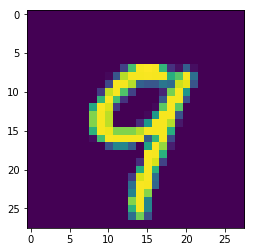

In [32]:
import matplotlib.pyplot as plt
IMGNO = 12
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model.
Let's start with a very simple linear classifier. All our models will have this basic interface -- they will take an image and return probabilities.

In [33]:
# Build Keras Model Using Keras Sequential API
def linear_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = [HEIGHT, WIDTH], name = "image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = NCLASSES, activation = tf.nn.softmax, name = "probabilities"))
    return model

In [34]:
def dnn_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = [HEIGHT, WIDTH], name = "image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Dense(units = NCLASSES, activation = tf.nn.softmax, name = "probabilities"))
    return model

## Write Input Functions

As usual, we need to specify input functions for training, evaluation, and predicition.

In [35]:
# Create training input function
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"image": x_train},
    y = y_train,
    batch_size = 100,
    num_epochs = None,
    shuffle = True,
    queue_capacity = 5000
  )

# Create evaluation input function
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"image": x_test},
    y = y_test,
    batch_size = 100,
    num_epochs = 1,
    shuffle = False,
    queue_capacity = 5000
  )

# Create serving input function for inference
def serving_input_fn():
    placeholders = {"image": tf.placeholder(dtype = tf.float32, shape = [None, HEIGHT, WIDTH])}
    features = placeholders # as-is
    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = placeholders)

## Create train_and_evaluate function

 tf.estimator.train_and_evaluate does distributed training.

In [36]:
def train_and_evaluate(output_dir, hparams):
    # Build Keras model
    model = linear_model()
        
    # Compile Keras model with optimizer, loss function, and eval metrics
    model.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"])
        
    # Convert Keras model to an Estimator
    estimator = tf.keras.estimator.model_to_estimator(
        keras_model = model, 
        model_dir = output_dir)

    # Set estimator's train_spec to use train_input_fn and train for so many steps
    train_spec = tf.estimator.TrainSpec(
        input_fn = train_input_fn,
        max_steps = hparams["train_steps"])

    # Create exporter that uses serving_input_fn to create saved_model for serving
    exporter = tf.estimator.LatestExporter(
        name = "exporter", 
        serving_input_receiver_fn = serving_input_fn)

    # Set estimator's eval_spec to use eval_input_fn and export saved_model
    eval_spec = tf.estimator.EvalSpec(
        input_fn = eval_input_fn,
        steps = None,
        exporters = exporter)

    # Run train_and_evaluate loop
    tf.estimator.train_and_evaluate(
        estimator = estimator, 
        train_spec = train_spec, 
        eval_spec = eval_spec)


In [91]:
def train_and_evaluate_dnn(output_dir, hparams):
    # Build Keras model
    model = dnn_model()
        
    # Compile Keras model with optimizer, loss function, and eval metrics
    model.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"])
        
    # Convert Keras model to an Estimator
    estimator = tf.keras.estimator.model_to_estimator(
        keras_model = model, 
        model_dir = output_dir)

    # Set estimator's train_spec to use train_input_fn and train for so many steps
    train_spec = tf.estimator.TrainSpec(
        input_fn = train_input_fn,
        max_steps = hparams["train_steps"])

    # Create exporter that uses serving_input_fn to create saved_model for serving
    exporter = tf.estimator.LatestExporter(
        name = "exporter", 
        serving_input_receiver_fn = serving_input_fn)

    # Set estimator's eval_spec to use eval_input_fn and export saved_model
    eval_spec = tf.estimator.EvalSpec(
        input_fn = eval_input_fn,
        steps = None,
        exporters = exporter)

    # Run train_and_evaluate loop
    tf.estimator.train_and_evaluate(
        estimator = estimator, 
        train_spec = train_spec, 
        eval_spec = eval_spec)
    
    preds = model.predict_classes(x_test)
    actuals = y_test
        
    return (preds, actuals)


In [81]:
def plain_keras():
    model = dnn_model()
        
    # Compile Keras model with optimizer, loss function, and eval metrics
    model.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"])
    
    model.fit(x_train, y_train)
    
    y_pred = model.predict_classes(x_test)
    
    return(y_test, y_pred)

In [82]:
(yt, yp) = plain_keras()

60000/60000 [==============================] - 7s 117us/sample - loss: 0.2693 - acc: 0.9208


In [83]:
yt[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [85]:
y_true = [np.argmax(yy) for yy in yt]

In [86]:
with tf.Session() as sess:
    with sess.as_default():
        cm = tf.confusion_matrix(yp, y_true).eval()

In [87]:
cm

array([[ 967,    0,    3,    0,    1,    3,    6,    1,    2,    5],
       [   0, 1122,    5,    0,    2,    1,    4,   12,    7,    6],
       [   3,    3, 1000,    6,    4,    0,    1,   16,    7,    2],
       [   1,    1,    5,  977,    0,   11,    0,    5,   14,   10],
       [   0,    0,    3,    0,  935,    2,    7,    0,    2,   18],
       [   3,    2,    1,    3,    3,  861,   20,    0,   10,    3],
       [   3,    1,    2,    0,    7,    1,  915,    0,    1,    0],
       [   1,    0,    8,    8,    1,    3,    0,  982,    6,    7],
       [   1,    5,    4,   15,    5,    8,    5,    1,  924,   10],
       [   1,    1,    1,    1,   24,    2,    0,   11,    1,  948]],
      dtype=int32)

This is the main() function

In [54]:
OUTDIR = "mnist/learned"
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {"train_steps": 1000, "learning_rate": 0.01}
train_and_evaluate(OUTDIR, hparams)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_service': None, '_is_chief': True, '_num_ps_replicas': 0, '_master': '', '_save_checkpoints_secs': 600, '_device_fn': None, '_train_distribute': None, '_evaluation_master': '', '_task_type': 'worker', '_tf_random_seed': None, '_task_id': 0, '_model_dir': 'mnist/learned', '_experimental_distribute': None, '_num_worker_replicas': 1, '_protocol': None, '_keep_checkpoint_max': 5, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_eval_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe46c1c66a0>, '_global_id_in_cluster': 0}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluatio

I got:

`Saving dict for global step 1000: categorical_accuracy = 0.9112, global_step = 1000, loss = 0.32516304`

In other words, we achieved 91.12% accuracy with the simple linear model!

Saving dict for global step 1000: categorical_accuracy = 0.9131, global_step = 1000, loss = 0.32085687

In [92]:
OUTDIR = "mnist/learned"
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {"train_steps": 2000, "learning_rate": 0.01}
(preds, actuals) = train_and_evaluate_dnn(OUTDIR, hparams)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_service': None, '_is_chief': True, '_num_ps_replicas': 0, '_master': '', '_save_checkpoints_secs': 600, '_device_fn': None, '_train_distribute': None, '_evaluation_master': '', '_task_type': 'worker', '_tf_random_seed': None, '_task_id': 0, '_model_dir': 'mnist/learned', '_experimental_distribute': None, '_num_worker_replicas': 1, '_protocol': None, '_keep_checkpoint_max': 5, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_eval_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe4867c7518>, '_global_id_in_cluster': 0}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluatio

AttributeError: module 'tensorflow_estimator.python.estimator.api.estimator' has no attribute 'train'

In [69]:
OUTDIR = "mnist/learned"
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {"train_steps": 2000, "learning_rate": 0.01}
(x_test, yhat, y) = train_and_evaluate_dnn(OUTDIR, hparams)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_service': None, '_is_chief': True, '_num_ps_replicas': 0, '_master': '', '_save_checkpoints_secs': 600, '_device_fn': None, '_train_distribute': None, '_evaluation_master': '', '_task_type': 'worker', '_tf_random_seed': None, '_task_id': 0, '_model_dir': 'mnist/learned', '_experimental_distribute': None, '_num_worker_replicas': 1, '_protocol': None, '_keep_checkpoint_max': 5, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_eval_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe4872c6198>, '_global_id_in_cluster': 0}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluatio

In [70]:
yhat

array([0, 2, 0, ..., 0, 0, 4])

In [71]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [41]:
xt1 == xt2.all()

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [12]:
yhat.shape

(10000, 10)

In [13]:
y.shape

(10000, 10)

In [14]:
yhat[1]

array([0.07035933, 0.13181132, 0.09147464, 0.14828543, 0.12785229,
       0.09173739, 0.0820067 , 0.09393556, 0.06346026, 0.09907712],
      dtype=float32)

In [15]:
np.argmax(yhat[1])

3

In [27]:
y_preds = [np.argmax(yh) for yh in yhat]

In [28]:
y_preds[:5]

# 6, 9, 4, 5, 9
# 8, 3, 3, 9, 9
# 2, 8, 6, 6, 8

[2, 8, 6, 6, 8]

In [18]:
yhat[:5]

array([[0.08068436, 0.10411207, 0.09924155, 0.1056537 , 0.10437905,
        0.09946482, 0.08825835, 0.0987853 , 0.11129862, 0.10812218],
       [0.07035933, 0.13181132, 0.09147464, 0.14828543, 0.12785229,
        0.09173739, 0.0820067 , 0.09393556, 0.06346026, 0.09907712],
       [0.08047639, 0.08944861, 0.11912595, 0.1252125 , 0.10308643,
        0.10109044, 0.10447406, 0.10603986, 0.07659378, 0.09445196],
       [0.09131777, 0.09115991, 0.09650643, 0.11250948, 0.09996839,
        0.08333775, 0.09256972, 0.12694798, 0.07699932, 0.12868327],
       [0.06651994, 0.09042523, 0.0902258 , 0.11480798, 0.09949264,
        0.10396718, 0.08482331, 0.11036616, 0.10495665, 0.1344151 ]],
      dtype=float32)

In [19]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [29]:
y_true = [np.argmax(yy) for yy in y]

In [30]:
y_true[:5]

# 7, 2, 1, 0, 4
# 7, 2, 1, 0, 4
# 7, 2, 1, 0, 4

[7, 2, 1, 0, 4]

In [42]:
with tf.Session() as sess:
    with sess.as_default():
        cm = tf.confusion_matrix(y_preds, y_true).eval()
        

Instructions for updating:
Use tf.cast instead.


In [43]:
cm

array([[  1,   1,  10,  27,   1,  10,   0,   6,  10,   1],
       [203,  78,  17,  37,  12,  96,  25,  57,  18,  11],
       [ 51,   0,  80,   8, 153,  42, 300,  75,  31, 134],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   5],
       [  0,   7,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [617, 961, 726, 653, 528, 479, 526, 738, 744, 777],
       [ 14,  52,  64,   8,  21,  35,  10,  52,  17,  17],
       [ 94,  35, 131, 277, 265, 229,  97,  96, 152,  61],
       [  0,   1,   3,   0,   2,   1,   0,   4,   2,   3]], dtype=int32)

In [44]:
from sklearn.metrics import confusion_matrix as skcm

In [45]:
skcm(y_preds, y_true)

array([[  1,   1,  10,  27,   1,  10,   0,   6,  10,   1],
       [203,  78,  17,  37,  12,  96,  25,  57,  18,  11],
       [ 51,   0,  80,   8, 153,  42, 300,  75,  31, 134],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   5],
       [  0,   7,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [617, 961, 726, 653, 528, 479, 526, 738, 744, 777],
       [ 14,  52,  64,   8,  21,  35,  10,  52,  17,  17],
       [ 94,  35, 131, 277, 265, 229,  97,  96, 152,  61],
       [  0,   1,   3,   0,   2,   1,   0,   4,   2,   3]])

In [ ]:
# First pass: Saving dict for global step 1000: categorical_accuracy = 0.9489, global_step = 1000, loss = 0.17488453
# added one dense layer, 64 units

# Second pass (another layer of 32 units): 
# Saving dict for global step 1000: categorical_accuracy = 0.9516, global_step = 1000, loss = 0.16565359

# Third pass: dropout layer with probability 0.5:
# Saving dict for global step 1000: categorical_accuracy = 0.9437, global_step = 1000, loss = 0.1882948

# Fourth pass: dropout layer with probability 0.1:
# Saving dict for global step 1000: categorical_accuracy = 0.9528, global_step = 1000, loss = 0.15361284

# Fifth pass: Upped second layer to 64 units:
# Saving dict for global step 1000: categorical_accuracy = 0.9539, global_step = 1000, loss = 0.14908159

# Sixth pass: Upped first layer to 128 units:
# Saving dict for global step 1000: categorical_accuracy = 0.9649, global_step = 1000, loss = 0.11287299

# 7th pass: Upped train steps to 2000:
# Saving dict for global step 2000: categorical_accuracy = 0.9707, global_step = 2000, loss = 0.094434

<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>